# Transfer learning to classifying horses and humans
This code is adapted starting from an example of Francois Chollet (see https://www.tensorflow.org/alpha/tutorials/images/transfer_learning) and explained in the book "Deep Learning with Tensorflow 2 and Keras" by Antonio Gulli, Amita Kapoor, Sujit Pal

### required modules

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt

### load the dataset

In [2]:
data, metadata = tfds.load(
    'horses_or_humans',
    with_info=True,
    as_supervised=True
)

raw_train = data['train']
raw_test = data['test']

### inspect some images

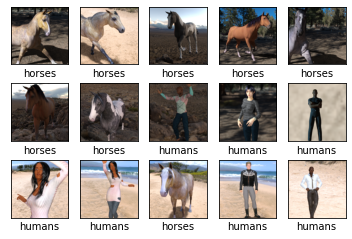

In [3]:
get_label_name = metadata.features['label'].int2str

def show_images(dataset):
    i = 0;
    for image, label in dataset.take(15):
        i = i + 1
        plt.subplot(3,5,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(get_label_name(label))        
        
        #plt.figure()
        #plt.imshow(image)
        #plt.title(get_label_name(label))

show_images(raw_train)

### resize images
resize the images to (160x160) with color values in range \[-1,1] which is what MobileNetV2 expects as input

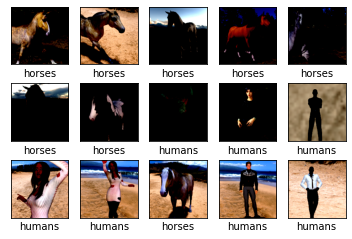

In [4]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
test = raw_test.map(format_example)

show_images(train)

### shuffle an batch
Shuffle and batch the training set, batch the test set

In [5]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 2000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

### create the model
create the model using MobileNet with input (160x160x3). The top layers are omitted include_top=False) since we are going to use our own top layer, and all the internal layers are frozen beacause we use the weights ptretrained on ImageNet

In [6]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False
base_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 10, 10, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 10, 10, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 10, 10, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 10, 10, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 10, 10, 64)   256         block_6_project[0][

### inspect a batch
let's inspect a batch and see if the shape is correct

In [7]:
for image_batch, label_batch in train_batches.take(1):
    pass
print("batch shape: ", image_batch.shape)

batch shape:  (32, 160, 160, 3)


### features batch
MobileNetV2 transforms each 160x160x3 image into 5x5x11280 block of features.

In [8]:
feature_batch = base_model(image_batch)
print("feature batch shape: ", feature_batch.shape)

feature batch shape:  (32, 5, 5, 1280)


### create the pooling layer
now, we can use `GlobalAveragePooling2D()` to average over the spatial 5x5 spatial locations and obtain a size of (32, 1280)

In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print("feature batch average shape: ", feature_batch_average.shape)

feature batch average shape:  (32, 1280)


### create the last layer (dense)

In [10]:
prediction_layer = tf.keras.layers.Dense(units=1)
prediction_batch = prediction_layer(feature_batch_average)
print("prediction batch shape: ", prediction_batch.shape)


prediction batch shape:  (32, 1)


### compose the final model
compose the final model by combining the `base_model` (pretrained MobileNetv2) with `global_average_layer` to get the correct shape output given as an input to the final `prediction_layer`

In [11]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### compile the model

In [12]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### evaluate the current model

In [13]:
loss0, accuracy0 = model.evaluate(test_batches)

8/8 [==============================] - 4s 485ms/step - loss: 6.1514 - accuracy: 0.4805


### train the model

In [14]:
initial_epochs = 10
history = model.fit(
    train_batches, 
    epochs=initial_epochs, 
    verbose = 1
)

Epoch 1/10
33/33 [==============================] - 15s 462ms/step - loss: 4.1478 - accuracy: 0.5433
Epoch 2/10
33/33 [==============================] - 15s 469ms/step - loss: 2.6816 - accuracy: 0.6475
Epoch 3/10
33/33 [==============================] - 15s 468ms/step - loss: 1.5735 - accuracy: 0.7663
Epoch 4/10
33/33 [==============================] - 15s 463ms/step - loss: 0.8576 - accuracy: 0.8481
Epoch 5/10
33/33 [==============================] - 15s 467ms/step - loss: 0.4311 - accuracy: 0.9211
Epoch 6/10
33/33 [==============================] - 15s 465ms/step - loss: 0.1860 - accuracy: 0.9523
Epoch 7/10
33/33 [==============================] - 16s 484ms/step - loss: 0.0923 - accuracy: 0.9757
Epoch 8/10
33/33 [==============================] - 16s 471ms/step - loss: 0.0417 - accuracy: 0.9883
Epoch 9/10
33/33 [==============================] - 16s 488ms/step - loss: 0.0150 - accuracy: 0.9971
Epoch 10/10
33/33 [==============================] - 16s 479ms/step - loss: 0.0069 - accura

In [15]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,accuracy,epoch
5,0.186020,0.952288,5
6,0.092288,0.975657,6
7,0.041694,0.988315,7
8,0.014979,0.997079,8
9,0.006898,0.996105,9


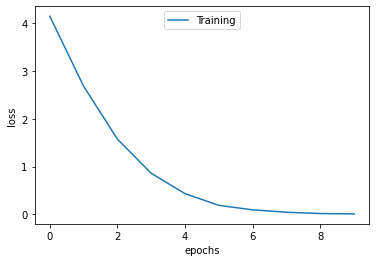

In [16]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history_df['epoch'], history_df['loss'], label='Training')
plt.legend(loc='upper center', shadow=False)

In [17]:
loss0, accuracy0 = model.evaluate(test_batches)

8/8 [==============================] - 4s 487ms/step - loss: 0.0446 - accuracy: 0.9883
